<a href="https://colab.research.google.com/github/maseerab/mini-project/blob/main/miniprojectnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.1548 - val_loss: 0.0124
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 9/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 10/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 11/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 12/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/s

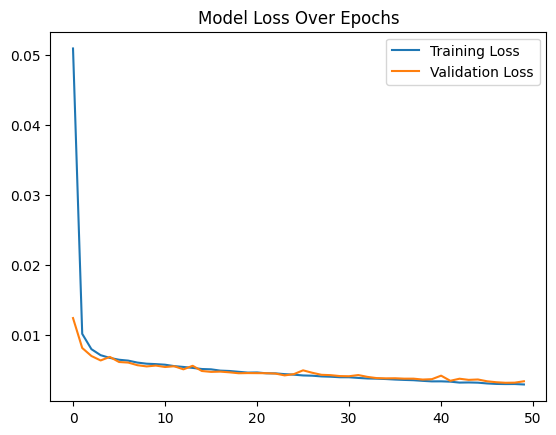

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout

# Load Data
data = pd.read_csv("Traffic.csv")
data = data.sort_values(by=['date_time']).reset_index(drop=True)

data['date_time'] = pd.to_datetime(data['date_time'], format='%d-%m-%Y %H:%M')
data['hour'] = data['date_time'].dt.hour
data['weekday'] = data['date_time'].dt.dayofweek + 1
data['month'] = data['date_time'].dt.month
data['year'] = data['date_time'].dt.year

data['is_holiday'] = data['is_holiday'].map(lambda x: 1 if x != 'None' else 0).astype(int)

# Generate Lag Features
for n in range(1, 7):
    data[f'last_{n}_hour_traffic'] = data['traffic_volume'].shift(n)
data.fillna(0, inplace=True)

# Select Features and Target
features = ['hour', 'weekday', 'month', 'year', 'is_holiday'] + [f'last_{n}_hour_traffic' for n in range(1, 7)]
target = ['traffic_volume']

X = data[features]
y = data[target]

# Normalize Features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Reshape Input for TFT (Samples, Time Steps, Features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-Test Split
trainX, testX, trainY, testY = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Build TFT Model
class TemporalFusionTransformer(Model):
    def __init__(self, input_dim, num_heads=4, dropout_rate=0.1):
        super(TemporalFusionTransformer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=input_dim)
        self.layer_norm1 = LayerNormalization()
        self.dropout1 = Dropout(dropout_rate)
        self.lstm = LSTM(input_dim, return_sequences=True)  # Change LSTM units to input_dim
        self.layer_norm2 = LayerNormalization()
        self.dropout2 = Dropout(dropout_rate)
        self.dense = Dense(1)

    def call(self, inputs):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        attn_output = self.layer_norm1(inputs + attn_output)
        lstm_output = self.lstm(attn_output)
        lstm_output = self.dropout2(lstm_output)
        lstm_output = self.layer_norm2(attn_output + lstm_output)  # Now shapes should match
        output = self.dense(lstm_output)
        return output
# Initialize and Compile Model
input_dim = X_reshaped.shape[2]
model = TemporalFusionTransformer(input_dim)
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), verbose=1)

# Evaluate Model
y_pred_scaled = model.predict(testX)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
testY_actual = scaler_y.inverse_transform(testY)

# Compute Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(testY_actual, y_pred)
mae = mean_absolute_error(testY_actual, y_pred)
rmse = np.sqrt(mean_squared_error(testY_actual, y_pred))

print(f"TFT Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()
